In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [11]:
def format_plot1(ax, title=None):
    if title is not None:
        ax.set_title(title)
    ax.grid()
    ax.set_xlabel("Filter size")
    ax.set_ylabel("Runtime (s)")
    return ax

# Point 1: Loop efficiency analysis

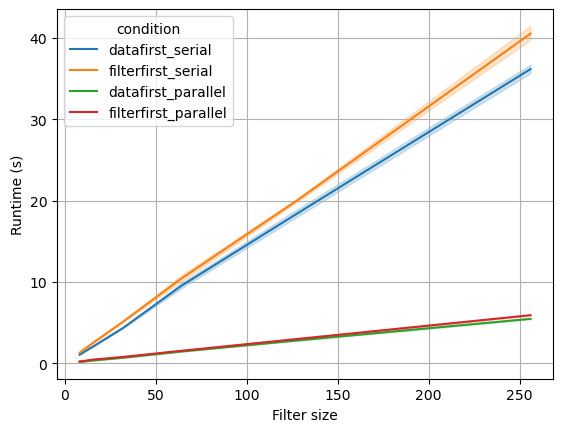

In [17]:
# Complete
exp_df = pd.read_csv("./results/experiment1.csv")
exp_df["condition"] = exp_df['type'].astype(str) +"_"+ exp_df["exec_type"]
exp_df["norm_time"] = exp_df["time"]/exp_df["filter_size"]

fig,ax = plt.subplots(1,1)
sns.lineplot(data=exp_df, x="filter_size", y="time", hue="condition", ax=ax)
ax = format_plot1(ax)
plt.show()


## Analysis

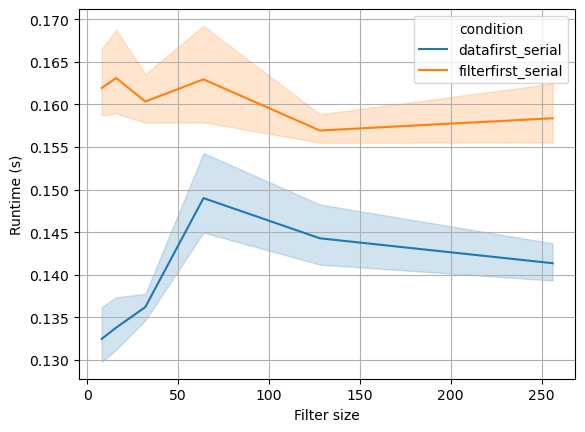

In [26]:
filtered_df = exp_df.loc[exp_df["exec_type"]=="serial"]
filtered_df.head()

fig,ax = plt.subplots(1,1)
sns.lineplot(data=filtered_df, x="filter_size", y="norm_time", hue="condition", ax=ax)
ax = format_plot1(ax)
plt.show()